<a href="https://colab.research.google.com/github/427paul/Machine_Learning/blob/main/DL_2_1_%ED%9A%8C%EA%B7%80_%EB%AA%A8%EB%8D%B8%EB%A7%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **딥러닝-회귀**


## **1.환경준비**

### (1) 라이브러리 Import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam

### (2) 필요 함수 생성

* 딥러닝을 위한 데이터로더 만들기

In [ ]:
def make_DataSet(x_train, x_val, y_train, y_val, batch_size = 32) :

    # 데이터 텐서로 변환
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
    x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

    # TensorDataset 생성 : 텐서 데이터셋으로 합치기
    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)

    # DataLoader 생성
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)

    return train_loader, x_val_tensor, y_val_tensor

* 학습을 위한 함수

In [ ]:
def train(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)                  # 전체 데이터셋의 크기
    num_batches = len(dataloader)                   # 배치 크기
    tr_loss = 0
    model.train()                                   # 훈련 모드로 설정
    for batch, (X, y) in enumerate(dataloader):     # batch : 현재 배치 번호, (X, y) : 입력 데이터와 레이블
        X, y = X.to(device), y.to(device)           # 입력 데이터와 레이블을 지정된 장치(device, CPU 또는 GPU)로 연결

        # Feed Forward
        pred = model(X)
        loss = loss_fn(pred, y)
        tr_loss += loss

        # Backpropagation
        loss.backward()             # 역전파를 통해 모델의 각 파라미터에 대한 손실의 기울기를 계산
        optimizer.step()            # 옵티마이저가 계산된 기울기를 사용하여 모델의 파라미터를 업데이트
        optimizer.zero_grad()       # 옵티마이저의 기울기 값 초기화. 기울기가 누적되는 것 방지

    tr_loss /= num_batches          # 모든 배치에서의 loss 평균

    return tr_loss.item()

* 검증을 위한 함수

In [ ]:
def evaluate(x_val_tensor, y_val_tensor, model, loss_fn, device):
    model.eval()                        # 모델을 평가 모드로 설정

    with torch.no_grad():               # 평가 과정에서 기울기를 계산하지 않도록 설정(메모리 사용을 줄이고 평가 속도를 높입니다.)
        x, y = x_val_tensor.to(device), y_val_tensor.to(device)
        pred = model(x)
        eval_loss = loss_fn(pred, y).item()    # 예측 값 pred와 실제 값 y 사이의 손실 계산

    return eval_loss, pred

* 학습곡선

In [ ]:
def dl_learning_curve(tr_loss_list, val_loss_list):

    epochs = list(range(1, len(tr_loss_list)+1))
    plt.plot(epochs, tr_loss_list, label='train_err', marker = '.')
    plt.plot(epochs, val_loss_list, label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) device 준비(cpu or gpu)

In [ ]:
# cpu 혹은 gpu 사용
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


### (4) 데이터로딩

In [ ]:
path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/boston.csv'
data = pd.read_csv(path)
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


|	변수	|	설명	|
|	----	|	----	|
|	medv	|	타운별 집값(중위수)	|
|	crim	|	범죄율	|
|	zn	|	25,000 평방피트를 초과 거주지역 비율	|
|	indus	|	비소매상업지역 면적 비율	|
|	chas	|	찰스강변 위치(범주 : 강변1, 아니면 0)	|
|	nox	|	일산화질소 농도	|
|	rm	|	주택당 방 수	|
|	age	|	1940년 이전에 건축된 주택의 비율	|
|	dis	|	직업센터의 거리	|
|	rad	|	방사형 고속도로까지의 거리	|
|	tax	|	재산세율	|
|	ptratio	|	학생/교사 비율	|
|	lstat	|	인구 중 하위 계층 비율	|


## **2.데이터 준비**

lstat, ptratio, crim 만 이용하여 medv를 예측하는 모델을 만들어 봅시다.

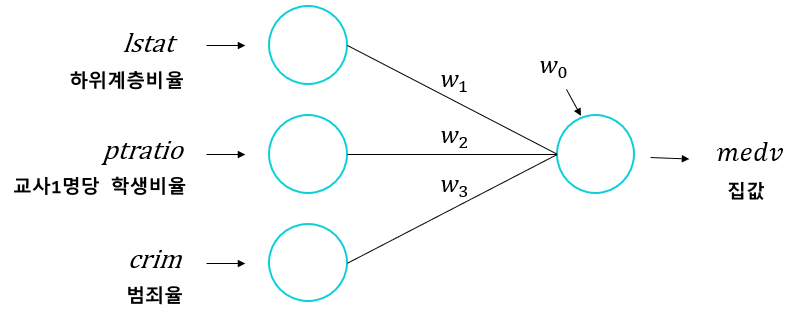

### (1) 데이터 준비
* x, y 나누기
    * x : lstat, ptratio, crim
    * y : medv

In [ ]:
target = 'medv'
features = ['lstat', 'ptratio', 'crim']
x = data.loc[:, features]
y = data.loc[:, target]

### (2) 가변수화

### (3) 데이터분할

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.2, random_state = 20)

### (4) Scaling

In [ ]:
# 스케일러 선언
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

## **3.모델링1 : feature 3개**

### (1) 딥러닝을 위한 준비작업

* make_DataLoader
    * train : 미니 배치 처리를 위한 데이터 로더로 만들기
    * val : 검증셋으로 성능 측정하면 되므로 텐서 그대로 사용

In [ ]:
train_loader, x_val_ts, y_val_ts = make_DataSet(x_train, x_val, y_train, y_val, 32)

In [ ]:
# 첫번째 배치만 로딩해서 살펴보기
for x, y in train_loader:
    print(f"Shape of x [rows, columns]: {x.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of x [rows, columns]: torch.Size([32, 3])
Shape of y: torch.Size([32, 1]) torch.float32


### (2) 모델 선언

* nn.Linear(입력, 출력) 레이어 한개를 추가해 봅시다.
    * [출력] 층의 **노드 수** 입니다.

In [ ]:
x.shape[1]

3

In [ ]:
n_feature = x.shape[1] # input feature가 3

# 모델 구조 설계
model1 = nn.Sequential(
  nn.Linear(n_feature, 1),#output layer가 1이니까
        ).to(device)

print(model1)

Sequential(
  (0): Linear(in_features=3, out_features=1, bias=True)
)


* Loss function과 Optimizer
    * loss function : MSE
    * Optimizer : Adam(모델 파라미터, 학습률)

In [ ]:
loss_fn = nn.MSELoss()
optimizer =Adam(model1.parameters(), lr=0.1)

### (3) 학습

In [ ]:
epochs = 50 # 데이터를 50번 반복 학습s = 50 # 데이터를 50번 반복 학습
tr_loss_list, val_loss_list = [], []

for t in range(epochs):
    tr_loss = train(train_loader, model1, loss_fn, optimizer, device)
    val_loss, _ = evaluate(x_val_ts, y_val_ts, model1, loss_fn, device)

    # 리스트에 loss 추가 --> learning curve 그리기 위해.
    tr_loss_list.append(tr_loss)
    val_loss_list.append(val_loss)

    print(f"Epoch {t+1}, train loss : {tr_loss:4f}, val loss : {val_loss:4f}")

Epoch 1, train loss : 577.872498, val loss : 446.820007
Epoch 2, train loss : 477.821259, val loss : 362.381958
Epoch 3, train loss : 396.742981, val loss : 294.941376
Epoch 4, train loss : 338.160583, val loss : 242.660202
Epoch 5, train loss : 287.613800, val loss : 203.642212
Epoch 6, train loss : 250.599533, val loss : 174.481445
Epoch 7, train loss : 228.388290, val loss : 153.992462
Epoch 8, train loss : 202.584549, val loss : 138.631073
Epoch 9, train loss : 188.824081, val loss : 128.078079
Epoch 10, train loss : 180.759750, val loss : 120.676781
Epoch 11, train loss : 170.963486, val loss : 114.801125
Epoch 12, train loss : 160.413635, val loss : 110.242081
Epoch 13, train loss : 157.175598, val loss : 106.549316
Epoch 14, train loss : 150.072571, val loss : 103.297562
Epoch 15, train loss : 145.109863, val loss : 100.275421
Epoch 16, train loss : 141.170074, val loss : 97.537827
Epoch 17, train loss : 138.997620, val loss : 95.039375
Epoch 18, train loss : 132.518295, val los

* 학습된 파라미터 확인

In [ ]:
for name, param in model1.named_parameters():
    if param.requires_grad:
        print(f"Parameter: {name}, Value: {param.data}")

Parameter: 0.weight, Value: tensor([[-13.6207,   7.3553, -23.1525]])
Parameter: 0.bias, Value: tensor([22.3250])


In [ ]:
# ['lstat', 'ptratio', 'crim'] : 변수
# 모델
# medv(예측값) = -13.6 * lstat + 7.4 * ptratio - 23.2 * crim

* 학습 곡선

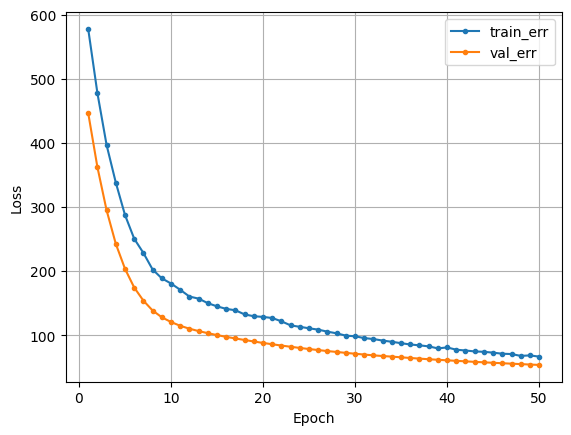

In [ ]:
dl_learning_curve(tr_loss_list, val_loss_list)

### (4) 모델 평가

In [ ]:
loss, pred = evaluate(x_val_ts, y_val_ts, model1, loss_fn, device)
print(f'MSE : {loss}') # MSE는 비즈니스 관점에서 설명이 어렵다

MSE : 53.757904052734375


* 평가 추가 : MAE, MAPE

In [ ]:
mae = mean_absolute_error(y_val_ts.numpy(), pred.numpy())
mape = mean_absolute_percentage_error(y_val_ts.numpy(), pred.numpy())
print(f'MAE : {mae}') # 평균 오차
print(f'MAPE : {mape}') # 평균오차율
# 숫자가 1000$ 단위
# MAE : 평균오차가 5100$정도 오차가 발생함
# MAPE : 25%의 오차가 발생함

MAE : 5.187591552734375
MAPE : 0.2529703974723816


## **4.모델링2 : feature 전체**
* 이제 전체 데이터를 가지고 모델링을 시도해 보겠습니다.


### (1) 데이터 전처리

* 데이터 분할

In [ ]:
target = 'medv'
x = data.drop(target, axis = 1)
y = data.loc[:, target]
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.2, random_state = 20)

* 스케일링

In [ ]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

### (2) 모델링

* make_DataLoader

In [ ]:
train_loader, x_val_ts, y_val_ts = make_DataSet(x_train, x_val, y_train, y_val)

* 모델 설계

In [ ]:
n_feature = x.shape[1]

# 모델 구조 설계
model2 = nn.Sequential(
                        nn.Linear(n_feature, 1)# 12개의 input이 하나의 output으로
                       ).to(device)

print(model2)

Sequential(
  (0): Linear(in_features=12, out_features=1, bias=True)
)


* Loss function과 Optimizer

In [ ]:
loss_fn = nn.MSELoss() # 회귀 모델의 손실함수는 MSE
optimizer = Adam(model2.parameters(), lr = 0.1)

### (3) 학습

In [ ]:
epochs = 50
tr_loss_list, val_loss_list = [], []

for t in range(epochs):
    tr_loss = train(train_loader, model2, loss_fn, optimizer, device) # train set 학습
    val_loss, _ = evaluate(x_val_ts, y_val_ts, model2, loss_fn, device) # val set으로 검증 평가

    # 리스트에 loss 추가 --> learning curve 그리기 위해.
    tr_loss_list.append(tr_loss) # 한 epoch 학습이 끝난 후, 최종 train set의 성능을 리스트에 추가
    val_loss_list.append(val_loss) # 한 epoch 학습이 끝난 후, 최종 val set의 성능을 리스트에 추가

    print(f"Epoch {t+1}, train loss : {tr_loss:4f}, val loss : {val_loss:4f}")

Epoch 1, train loss : 300.864502, val loss : 187.687592
Epoch 2, train loss : 207.474945, val loss : 137.808075
Epoch 3, train loss : 166.456696, val loss : 119.538475
Epoch 4, train loss : 147.775787, val loss : 107.570229
Epoch 5, train loss : 134.313049, val loss : 96.584610
Epoch 6, train loss : 121.848358, val loss : 86.373985
Epoch 7, train loss : 108.206146, val loss : 78.071617
Epoch 8, train loss : 99.118767, val loss : 71.173653
Epoch 9, train loss : 90.839386, val loss : 65.536095
Epoch 10, train loss : 84.125847, val loss : 60.775745
Epoch 11, train loss : 80.083733, val loss : 57.064091
Epoch 12, train loss : 76.194267, val loss : 53.969799
Epoch 13, train loss : 70.677132, val loss : 51.687126
Epoch 14, train loss : 67.961357, val loss : 49.688946
Epoch 15, train loss : 65.506813, val loss : 48.287392
Epoch 16, train loss : 64.051025, val loss : 46.571747
Epoch 17, train loss : 60.052307, val loss : 45.459179
Epoch 18, train loss : 58.785889, val loss : 44.539196
Epoch 19

* 학습된 파라미터 확인

In [ ]:
for name, param in model2.named_parameters():
    if param.requires_grad:
        print(f"Parameter: {name}, Value: {param.data}")

Parameter: 0.weight, Value: tensor([[ -9.8476,   7.0223,  -0.1022,   5.4694,   1.4610,  17.8301,   6.6181,
           5.1298,   0.5017,  -2.9637,   0.2079, -16.8783]])
Parameter: 0.bias, Value: tensor([12.3444])


* 학습 곡선

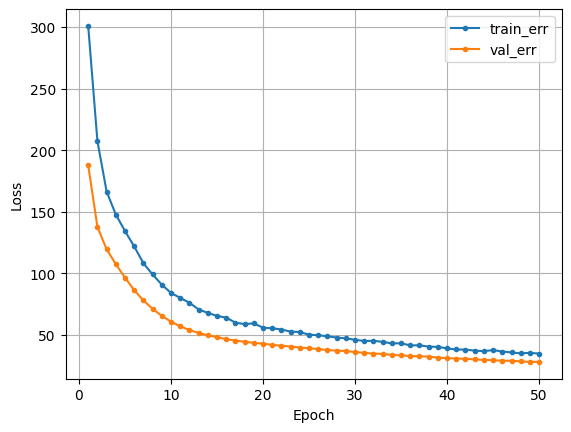

In [ ]:
dl_learning_curve(tr_loss_list, val_loss_list)

### (4) 모델 평가

In [ ]:
loss, pred = evaluate(x_val_ts, y_val_ts, model2, loss_fn, device)

mae = mean_absolute_error(y_val_ts.numpy(), pred.numpy())
mape = mean_absolute_percentage_error(y_val_ts.numpy(), pred.numpy())

print(f'MSE : {loss}')
print(f'MAE : {mae}')
print(f'MAPE : {mape}') # MAPE : 데이터를 12개 다 사용하니 오차율이 20%로 줄었음

MSE : 28.133527755737305
MAE : 4.1279168128967285
MAPE : 0.20925118029117584


## **5.모델링3 : 은닉층 추가**

### (1) 데이터 전처리
4.모델링2 에서 준비한 데이터를 이용합니다.

### (2) 모델링
4.모델링2 에서 선언한 DataLoader를 그대로 사용합니다.

* 모델 설계

In [ ]:
n_feature = x.shape[1] # 특징 12개

# 모델 구조 설계
model3 = nn.Sequential(
            nn.Linear(n_feature, 2), # 은닉층 2개
            nn.ReLU(), # 은닉층에는 활성화 함수가 필요함(다음 레이어에 결과값 전달 방법 결정)
            nn.Linear(2, 1), # 은닉층 2개의 결과물 output 1개
        ).to(device)

print(model3)

Sequential(
  (0): Linear(in_features=12, out_features=2, bias=True)
  (1): ReLU()
  (2): Linear(in_features=2, out_features=1, bias=True)
)


* Loss function과 Optimizer

In [ ]:
loss_fn = nn.MSELoss()
optimizer = Adam(model3.parameters(), lr = 0.1)

### (3) 학습

In [ ]:
epochs = 100
tr_loss_list, val_loss_list = [], []

for t in range(epochs):
    tr_loss = train(train_loader, model3, loss_fn, optimizer, device)
    val_loss, _ = evaluate(x_val_ts, y_val_ts, model3, loss_fn, device)

    # 리스트에 loss 추가 --> learning curve 그리기 위해.
    tr_loss_list.append(tr_loss)
    val_loss_list.append(val_loss)

    print(f"Epoch {t+1}, train loss : {tr_loss:4f}, val loss : {val_loss:4f}")

Epoch 1, train loss : 496.026520, val loss : 224.595413
Epoch 2, train loss : 188.290024, val loss : 146.075775
Epoch 3, train loss : 137.446396, val loss : 79.449677
Epoch 4, train loss : 91.458504, val loss : 58.292259
Epoch 5, train loss : 70.992615, val loss : 46.969036
Epoch 6, train loss : 58.331566, val loss : 43.072041
Epoch 7, train loss : 54.413494, val loss : 39.918213
Epoch 8, train loss : 50.578438, val loss : 37.478840
Epoch 9, train loss : 47.510868, val loss : 34.293068
Epoch 10, train loss : 42.806736, val loss : 32.994610
Epoch 11, train loss : 39.246910, val loss : 29.639854
Epoch 12, train loss : 36.578312, val loss : 27.584152
Epoch 13, train loss : 34.176537, val loss : 27.852470
Epoch 14, train loss : 33.147381, val loss : 23.975742
Epoch 15, train loss : 31.884830, val loss : 22.810379
Epoch 16, train loss : 28.999794, val loss : 24.971931
Epoch 17, train loss : 27.757704, val loss : 21.351374
Epoch 18, train loss : 26.763235, val loss : 21.824451
Epoch 19, trai

* 학습된 파라미터 확인

In [ ]:
for name, param in model3.named_parameters():
    if param.requires_grad:
        print(f"Parameter: {name}, Value: {param.data}")

Parameter: 0.weight, Value: tensor([[ -0.7246,  -0.5271,  -0.7370,  -0.6255,  -0.7087,  -0.4443,  -0.7187,
          -0.8719,  -0.3973,  -0.4149,  -0.6612,  -0.3881],
        [ -4.6369,   0.7783,   0.6187,   0.5976,  -2.7181,   5.4928,   1.1247,
          -3.6799,   1.9337,  -1.4237,  -1.7223, -10.6774]])
Parameter: 0.bias, Value: tensor([-0.5421,  4.7873])
Parameter: 2.weight, Value: tensor([[0.4514, 3.6253]])
Parameter: 2.bias, Value: tensor([11.3201])


* 학습 곡선

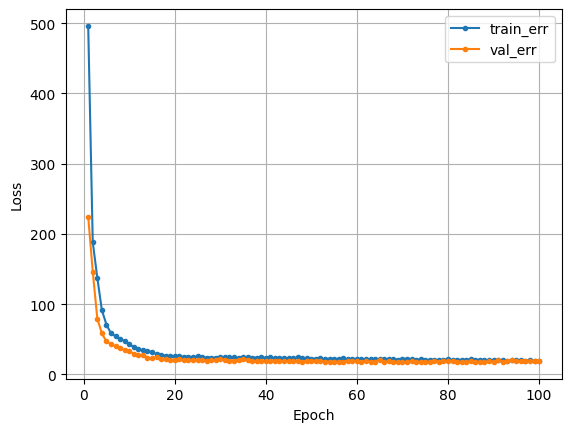

In [ ]:
dl_learning_curve(tr_loss_list, val_loss_list)

### (4) 모델 평가

In [ ]:
loss, pred = evaluate(x_val_ts, y_val_ts, model3, loss_fn, device)

mae = mean_absolute_error(y_val_ts.numpy(), pred.numpy())
mape = mean_absolute_percentage_error(y_val_ts.numpy(), pred.numpy())

print(f'MSE : {loss}')
print(f'MAE : {mae}')
print(f'MAPE : {mape}') # 오차 17%로 줄었음

MSE : 19.307403564453125
MAE : 3.382078170776367
MAPE : 0.17437835037708282


## **6.실습1**
* 여러분은 다음의 구조대로 모델링을 수행하고 성능평가를 해 봅시다.
    * 모델 구조
            Sequential(
              (0): Linear(in_features=12, out_features=10, bias=True)
              (1): ReLU()
              (2): Linear(in_features=10, out_features=5, bias=True)
              (3): ReLU()
              (4): Linear(in_features=5, out_features=1, bias=True)
            )
    * epochs(반복횟수) : 100
    * lr(learning rate, 학습률) : 0.01

* 모델 설계

In [ ]:
n_feature = x.shape[1]

model4 = nn.Sequential(
    nn.Linear(n_feature, 10),
    nn.ReLU(),
    nn.Linear(10,5),
    nn.ReLU(),
    nn.Linear(5,1)
).to(device)

print(model4)

Sequential(
  (0): Linear(in_features=12, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=5, bias=True)
  (3): ReLU()
  (4): Linear(in_features=5, out_features=1, bias=True)
)


* Loss function과 Optimizer

In [ ]:
loss_fn = nn.MSELoss()
optimizer = Adam(model4.parameters(), lr = 0.01)

* 학습

In [ ]:
epochs = 100
tr_loss_list, val_loss_list = [], []

for t in range(epochs):
  tr_loss = train(train_loader, model4, loss_fn, optimizer, device)
  val_loss, _ = evaluate(x_val_ts, y_val_ts, model4, loss_fn, device)

  tr_loss_list.append(tr_loss)
  val_loss_list.append(val_loss)

  print(f"Epoch {t+1}, train loss : {tr_loss:4f}, val loss : {val_loss:4f}")

Epoch 1, train loss : 591.841736, val loss : 513.860657
Epoch 2, train loss : 571.055908, val loss : 469.985291
Epoch 3, train loss : 486.130402, val loss : 335.266266
Epoch 4, train loss : 300.195435, val loss : 153.010742
Epoch 5, train loss : 184.453262, val loss : 131.354523
Epoch 6, train loss : 144.966492, val loss : 100.833916
Epoch 7, train loss : 122.128700, val loss : 87.110245
Epoch 8, train loss : 106.499702, val loss : 75.675903
Epoch 9, train loss : 92.185379, val loss : 65.402878
Epoch 10, train loss : 79.179024, val loss : 56.527508
Epoch 11, train loss : 70.672821, val loss : 50.879730
Epoch 12, train loss : 63.849167, val loss : 47.155937
Epoch 13, train loss : 60.088676, val loss : 43.915581
Epoch 14, train loss : 56.693802, val loss : 42.929520
Epoch 15, train loss : 54.045082, val loss : 40.879745
Epoch 16, train loss : 52.258060, val loss : 39.387589
Epoch 17, train loss : 49.872681, val loss : 38.176895
Epoch 18, train loss : 48.731686, val loss : 37.330635
Epoch

* 학습 곡선

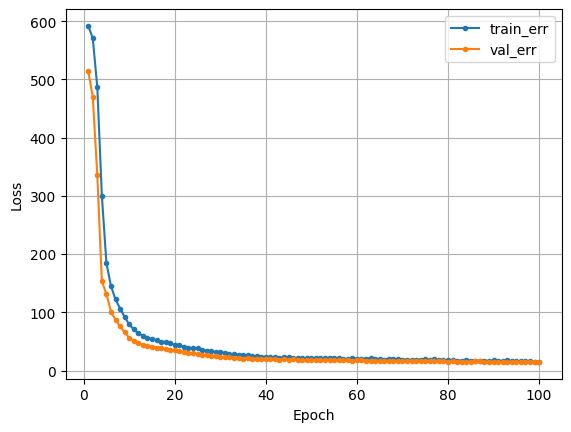

In [ ]:
dl_learning_curve(tr_loss_list, val_loss_list)

* 모델 평가 : MSE

In [ ]:
loss, pred = evaluate(x_val_ts, y_val_ts, model4, loss_fn, device)

mae = mean_absolute_error(y_val_ts.numpy(), pred.numpy())
mape = mean_absolute_percentage_error(y_val_ts.numpy(), pred.numpy())

print(f'MSE : {loss}')
print(f'MAE : {mae}')
print(f'MAPE : {mape}')

MSE : 14.999648094177246
MAE : 2.951451063156128
MAPE : 0.1592094600200653


## **7.실습2**
* 이번에는 여러분이 원하는 구조와 하이퍼파라미터 값을 조정하여 성능을 높여 봅시다.

* 모델 설계

* Loss function과 Optimizer

* 학습

* 학습 곡선

* 모델 평가 : MSE